In [86]:
!pip install xgboost

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [87]:
df=pd.read_csv("META  BP DATA.csv")

In [88]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,60.459999,62.660000,60.240002,62.619999,59291000.0,3.0,0.100002,3658.399902
1,02-04-2014,63.209999,63.910000,62.209999,62.720001,66277000.0,4.0,-3.229999,3665.989990
2,03-04-2014,62.549999,63.169998,59.130001,59.490002,83859000.0,5.0,-2.740002,3637.580078
3,04-04-2014,59.939999,60.200001,56.320000,56.750000,125214400.0,6.0,0.200001,3539.379883
4,07-04-2014,55.900002,58.000000,55.439999,56.950001,108488000.0,2.0,1.239998,3507.750000


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2205 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


## Convert the "time" column to the datetime type

In [90]:
df["Date"] = pd.to_datetime(df["Date"])

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2205 non-null   datetime64[ns]
 1   Open             2205 non-null   float64       
 2   High             2205 non-null   float64       
 3   Low              2205 non-null   float64       
 4   Close            2205 non-null   float64       
 5   Volume           2205 non-null   float64       
 6   Day of the week  2205 non-null   float64       
 7   Change           2205 non-null   float64       
 8   NASDAQ           2205 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 159.5 KB


In [92]:
df.set_index('Date',inplace=True)

In [95]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,60.459999,62.660000,60.240002,62.619999,59291000.0,3.0,0.100002,3658.399902
2014-02-04,63.209999,63.910000,62.209999,62.720001,66277000.0,4.0,-3.229999,3665.989990
2014-03-04,62.549999,63.169998,59.130001,59.490002,83859000.0,5.0,-2.740002,3637.580078
2014-04-04,59.939999,60.200001,56.320000,56.750000,125214400.0,6.0,0.200001,3539.379883
2014-07-04,55.900002,58.000000,55.439999,56.950001,108488000.0,2.0,1.239998,3507.750000


In [96]:
df = df.iloc[:-62, :]

In [97]:
df.tail()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2022-12-23,116.029999,118.180000,115.540001,118.040001,17796600.0,6.0,-1.160004,10985.45020
2022-12-27,117.930000,118.599998,116.050003,116.879997,21392300.0,3.0,-1.259994,10822.50977
2022-12-28,116.250000,118.150002,115.510002,115.620003,19612500.0,4.0,4.639999,10679.33984
2022-12-29,116.400002,121.029999,115.769997,120.260002,22366200.0,5.0,0.079994,10951.04981
2022-12-30,118.160004,120.419998,117.739998,120.339996,19583800.0,6.0,4.400002,10939.75977


# Missing entries


In [98]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [99]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [100]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [101]:
all_datetimes.shape

(3283,)

# Supplying missing values


## Insert missing datetimes

In [102]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [103]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2205 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 359.9 KB


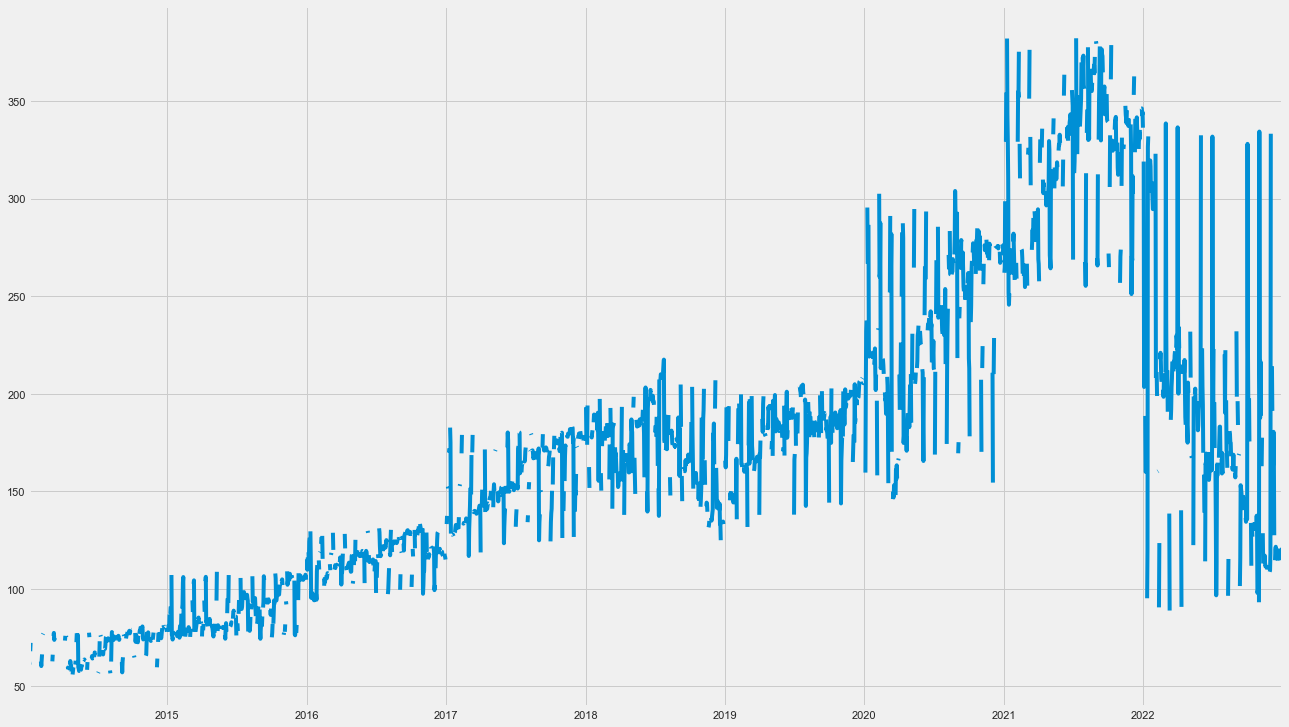

In [104]:
plot = df['Close'].plot(figsize=(20, 12))

# forward fill

In [105]:
df["ffilled"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ,ffilled
2014-01-04,60.459999,62.660000,60.240002,62.619999,59291000.0,3.0,0.100002,3658.399902,62.619999
2014-01-05,60.430000,62.279999,60.209999,61.150002,82429000.0,5.0,-0.690003,3594.360107,61.150002
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3594.360107,61.150002
2014-01-07,67.580002,68.440002,67.389999,68.059998,33243000.0,3.0,-1.610001,3894.330078,68.059998
2014-01-08,72.220001,73.220001,71.550003,72.360001,43535000.0,6.0,1.150001,3879.669922,72.360001
2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3879.669922,72.360001
2014-01-10,78.779999,78.820000,75.900002,76.550003,55090000.0,4.0,0.529999,3984.739990,76.550003
2014-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3984.739990,76.550003
2014-01-12,77.260002,77.309998,74.800003,75.099998,31789900.0,2.0,0.360001,4287.810059,75.099998
2014-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4287.810059,75.099998


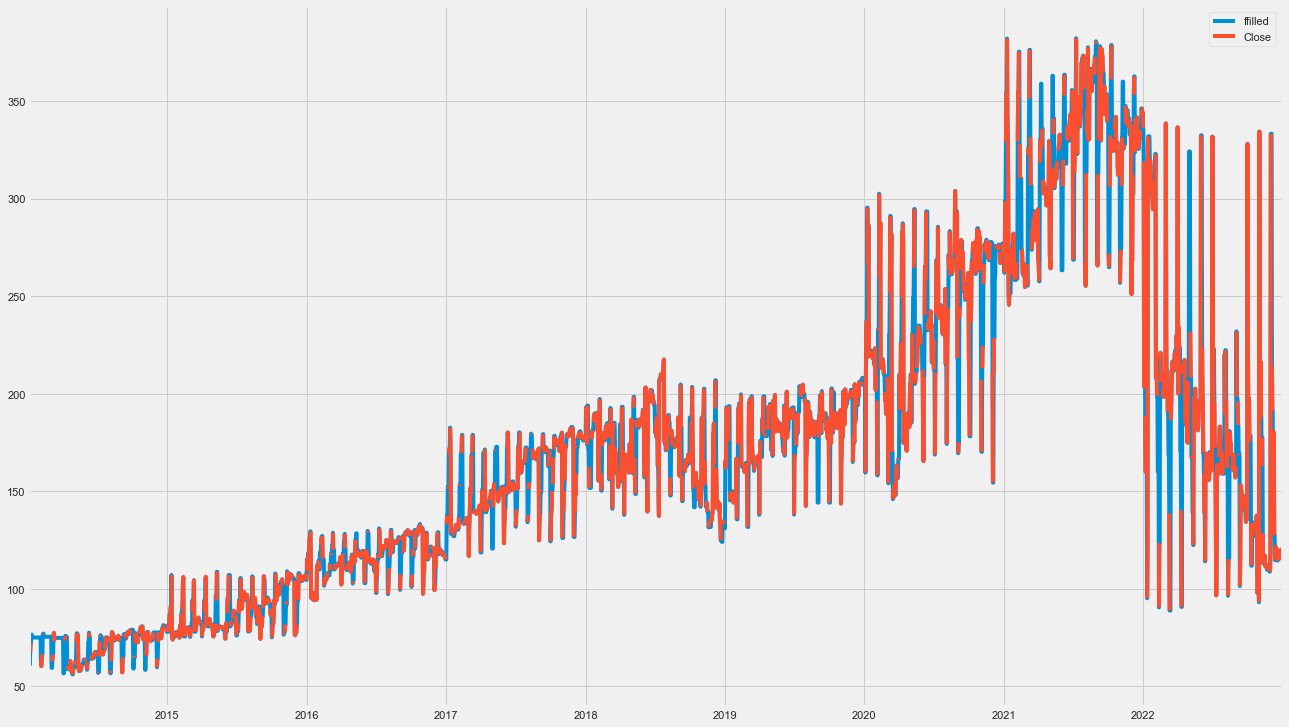

In [106]:
df = df[["ffilled", "Close","NASDAQ","Change"]]
plot = df[["ffilled", "Close"]].plot(figsize=(20, 12))

In [107]:
df.ffilled

2014-01-04     62.619999
2014-01-05     61.150002
2014-01-06     61.150002
2014-01-07     68.059998
2014-01-08     72.360001
                 ...    
2022-12-26    118.040001
2022-12-27    116.879997
2022-12-28    115.620003
2022-12-29    120.260002
2022-12-30    120.339996
Freq: D, Name: ffilled, Length: 3283, dtype: float64

In [108]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close,NASDAQ,Change
2014-01-04,62.619999,62.619999,3658.399902,0.100002
2014-01-05,61.150002,61.150002,3594.360107,-0.690003
2014-01-06,61.150002,NaN,3594.360107,NaN
2014-01-07,68.059998,68.059998,3894.330078,-1.610001
2014-01-08,72.360001,72.360001,3879.669922,1.150001
...,...,...,...,...
2022-12-26,118.040001,NaN,10985.450200,NaN
2022-12-27,116.879997,116.879997,10822.509770,-1.259994
2022-12-28,115.620003,115.620003,10679.339840,4.639999
2022-12-29,120.260002,120.260002,10951.049810,0.079994


In [109]:
df.drop(["Close"],axis=1,inplace=True)

In [110]:
df

,close,NASDAQ,Change
2014-01-04,62.619999,3658.399902,0.100002
2014-01-05,61.150002,3594.360107,-0.690003
2014-01-06,61.150002,3594.360107,NaN
2014-01-07,68.059998,3894.330078,-1.610001
2014-01-08,72.360001,3879.669922,1.150001
...,...,...,...
2022-12-26,118.040001,10985.450200,NaN
2022-12-27,116.879997,10822.509770,-1.259994
2022-12-28,115.620003,10679.339840,4.639999
2022-12-29,120.260002,10951.049810,0.079994


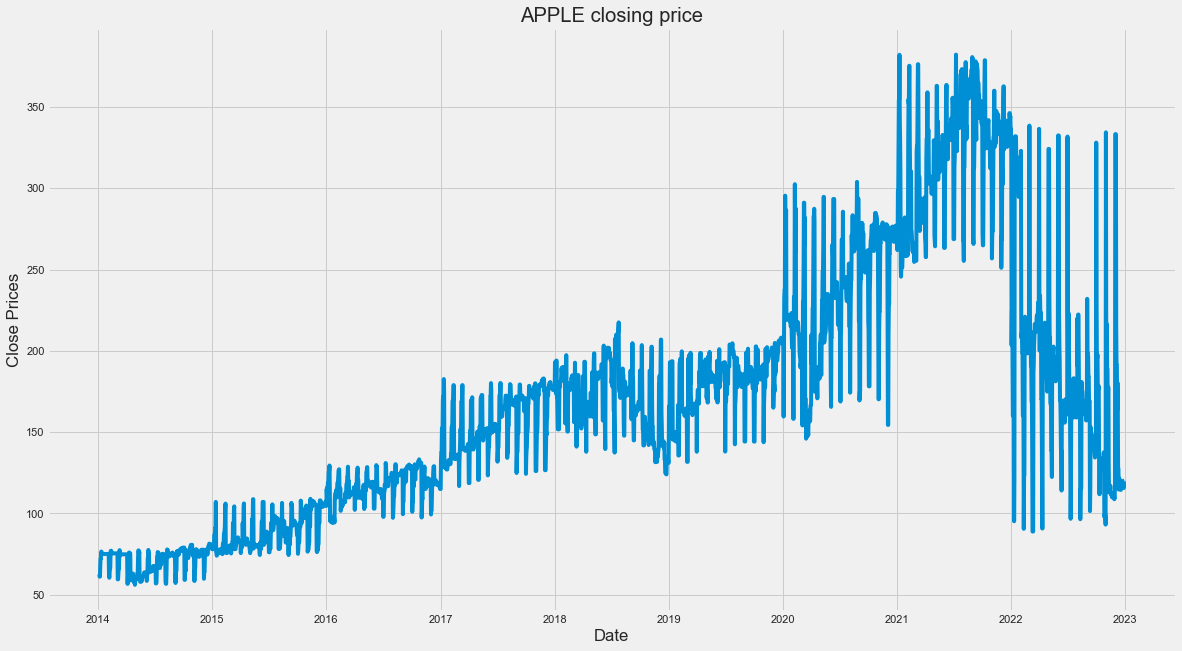

In [111]:
#plot close price
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('APPLE closing price')
plt.show()

# checking stationarity of the data


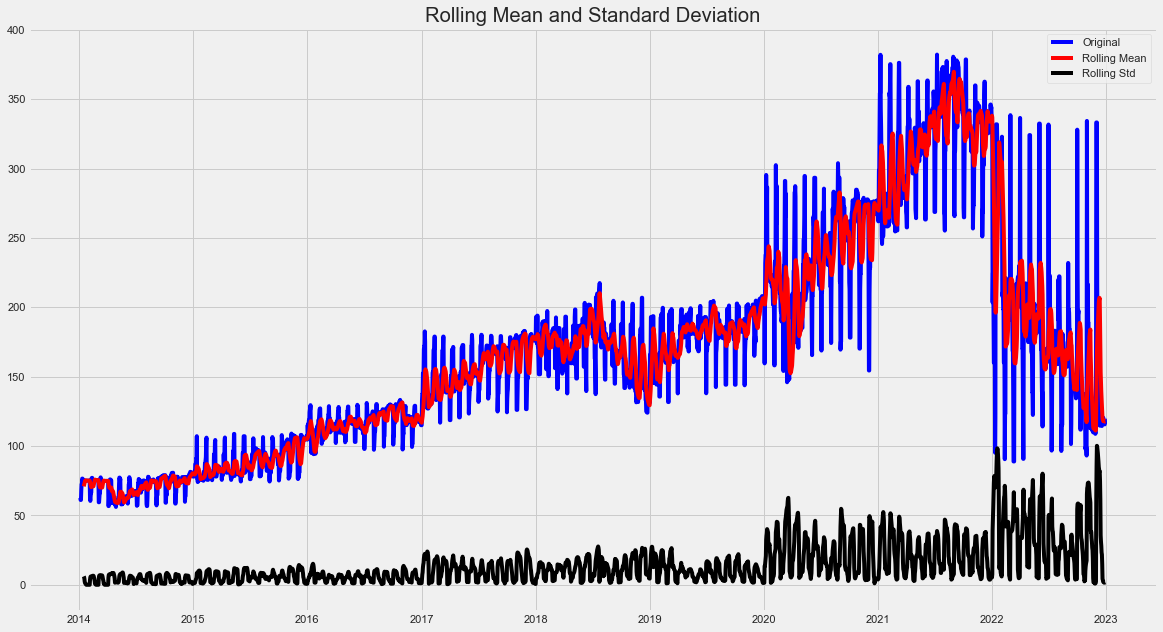

Results of dickey fuller test
Test Statistics                  -1.270421
p-value                           0.642594
No. of lags used                 29.000000
Number of observations used    3253.000000
critical value (1%)              -3.432362
critical value (5%)              -2.862429
critical value (10%)             -2.567243
dtype: float64


In [112]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.figure(figsize=(18, 10))

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df.close)

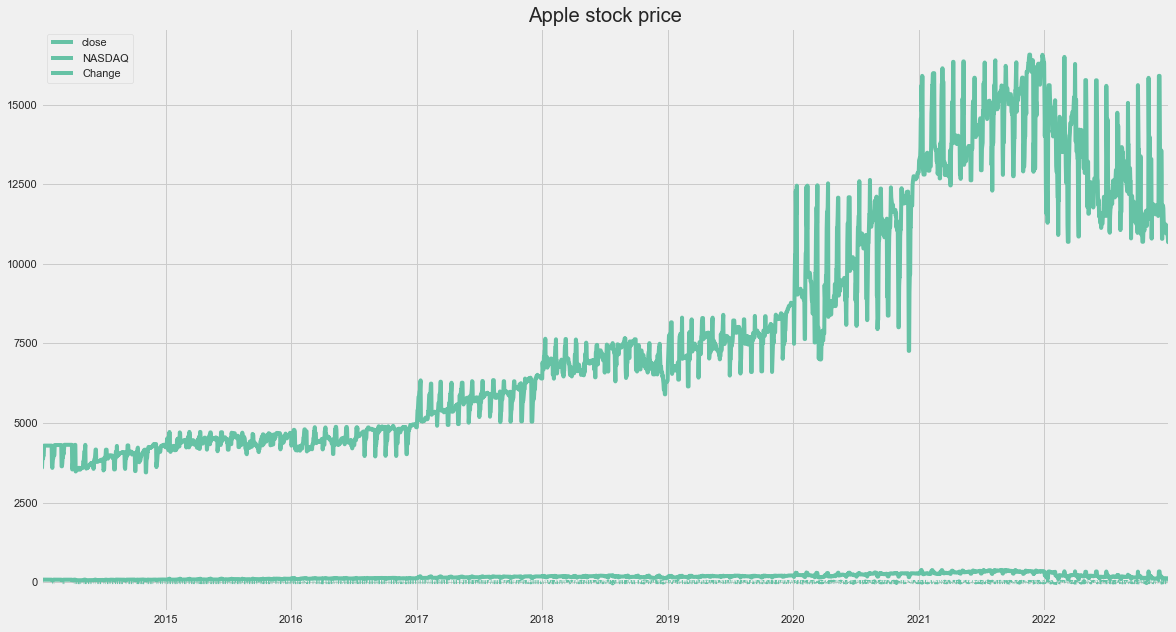

In [113]:
df.plot(style='-',
        figsize=(18, 10),
        color=color_pal[0],
        title='Apple stock price')
plt.show()

## Train / Test Split¶


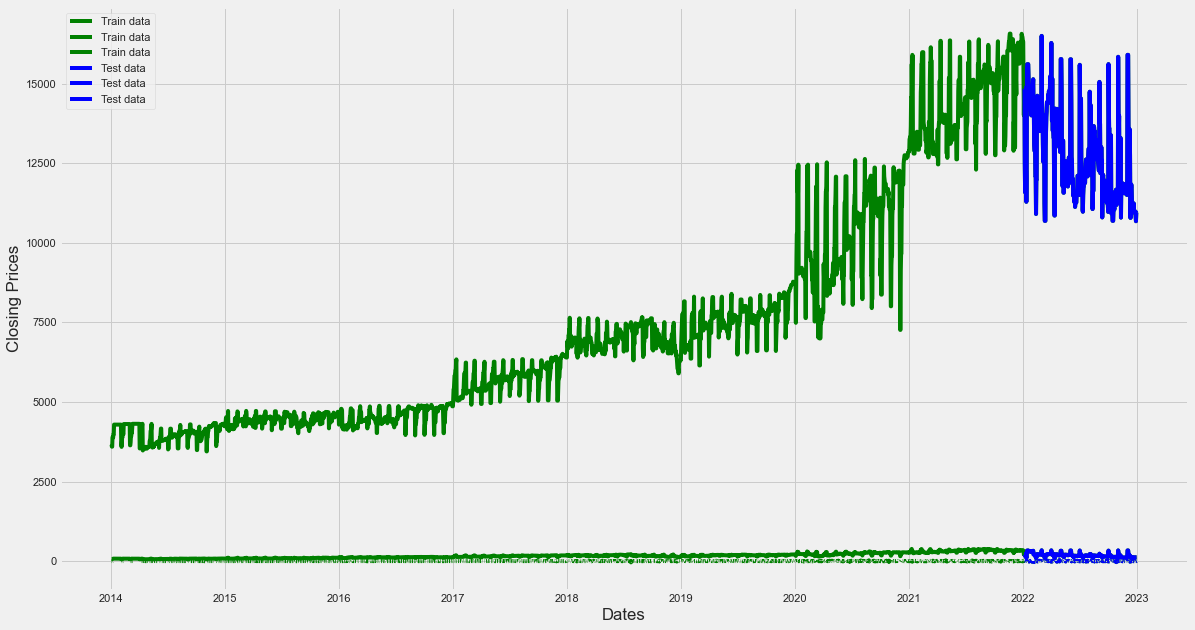

In [114]:
train_data = df.loc[df.index < '01-04-2022']
test_data = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [115]:
train_data.shape

(2922, 3)

In [116]:
test_data.tail()

,close,NASDAQ,Change
2022-12-26,118.040001,10985.45020,NaN
2022-12-27,116.879997,10822.50977,-1.259994
2022-12-28,115.620003,10679.33984,4.639999
2022-12-29,120.260002,10951.04981,0.079994
2022-12-30,120.339996,10939.75977,4.400002


In [117]:
test_data.shape

(361, 3)

In [118]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship¶


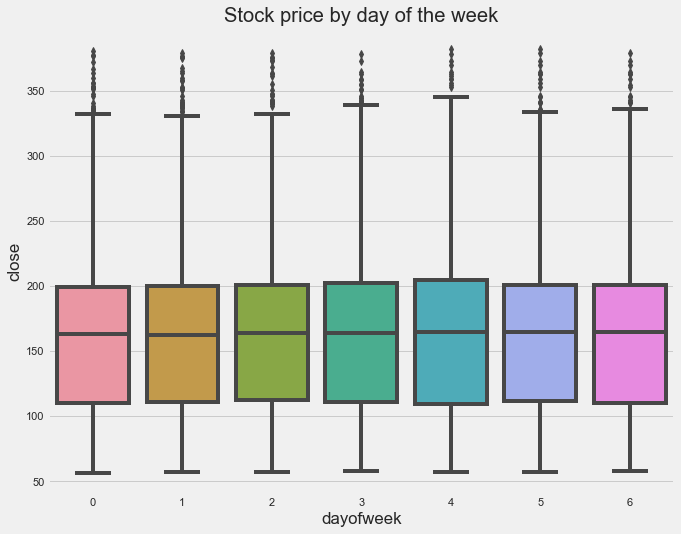

In [119]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='close')
ax.set_title('Stock price by day of the week')
plt.show()

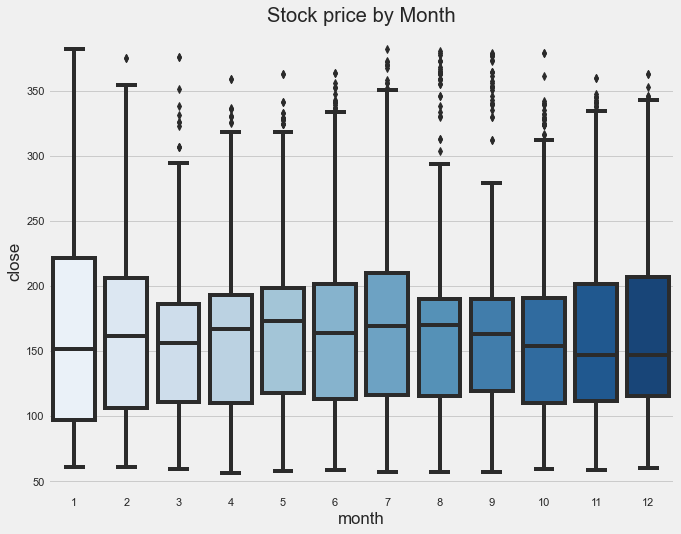

In [120]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='close', palette='Blues')
ax.set_title('Stock price by Month')
plt.show()

# Create our Model¶


In [121]:
train = create_features(train_data)
test = create_features(test_data)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','NASDAQ','Change']
TARGET = 'close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [122]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:183.28821	validation_1-rmse:187.03446
[100]	validation_0-rmse:68.47008	validation_1-rmse:44.20900
[148]	validation_0-rmse:43.37389	validation_1-rmse:59.45218


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance¶


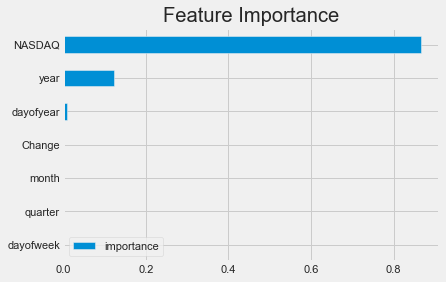

In [123]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test


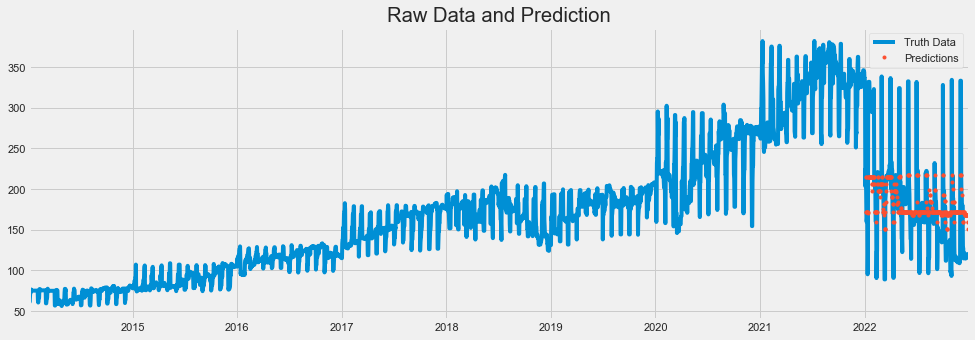

In [124]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [125]:
df['prediction'].tail(365)

2021-12-31           NaN
2022-01-01           NaN
2022-01-02           NaN
2022-01-03           NaN
2022-01-04    215.160110
                 ...    
2022-12-26    168.067566
2022-12-27    159.285339
2022-12-28    150.999191
2022-12-29    159.285339
2022-12-30    159.285339
Freq: D, Name: prediction, Length: 365, dtype: float32

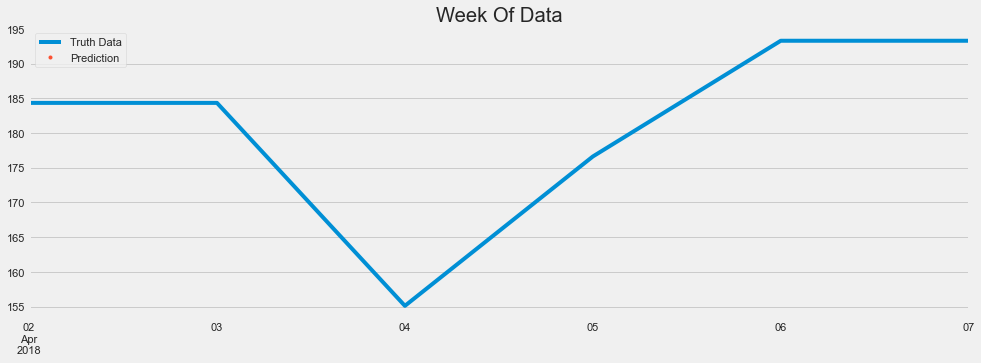

In [126]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['close'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [127]:
score = np.sqrt(mean_squared_error(test['close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 44.20


# Calculate error

In [128]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-03-01    123.379899
2022-04-01    121.369889
2022-11-01    117.037506
2022-01-17    116.739884
2022-01-15    116.739884
2022-01-14    116.739884
2022-01-16    116.739884
2022-12-03    115.927521
2022-12-02    115.927521
2022-12-01    115.927521
Name: error, dtype: float64

In [129]:
# report performance
mse = mean_squared_error(test['prediction'], test[TARGET])
print('MSE: '+str(mse))
mae = mean_absolute_error(test['prediction'], test[TARGET])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test['prediction'], test[TARGET]))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test[TARGET] - test['prediction'])/np.abs(test['prediction']))
print('MAPE: '+str(mape))

MSE: 1953.4041053538574
MAE: 31.26365196498983
RMSE: 44.19733142797037
MAPE: 0.16981165634973297
